In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import *
from numpy import linalg as la
import glob
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import tqdm
from matplotlib import pyplot as plt
import keras
from matplotlib import pyplot as plt

Using TensorFlow backend.


Loading data from datasets

In [0]:
def data_processing(name):
    path='/content/drive/My Drive/comp9417-project/SVD based on user and movie features/ml-100k/u.item'
    r_cols = ['userId', 'movieId', 'rating',"timeStamp"]
    ratings = pd.read_csv(name, sep='\t', names=r_cols,encoding='latin-1')
    ratings.drop('timeStamp',axis=1, inplace=True)
    # a = ratings['user_id'].value_counts().index.tolist()
    m_cols = ['movieId', 'title', 'release_date'] 
    movies = pd.read_csv(path, sep='|', names=m_cols, usecols=range(3),encoding='latin-1')
    test=pd.merge(ratings,movies,how='outer',on='movieId')
    trainRatingsPivotDF=test.pivot_table(index='userId',columns='movieId',values='rating',fill_value=0)
    return trainRatingsPivotDF
    

In [0]:
# decrease dimension of sigma to smaller one which keep 90% original information
# and return new dimension.
def findDimension(sigma):
    count = 0
    sig2 = sigma**2
    sumsig = sum(sig2)
    for i in range(len(sig2)):
        count += sig2[i]
        if count >= 0.9*sumsig:
            return i

# Using pearson corelation to calculate similarity of two vectors.
def pearsSim(A,B):
    if len(A)<3:return 1.0
    return 0.5+0.5*corrcoef(A,B,rowvar=0)[0][1]


In [0]:
def recommand(dataMat,user,N='all'):
    unratedItems = nonzero(dataMat[user,:].A == 0)[1]
    
    if len(unratedItems)==0: return 'you rated every movies.'
    itemScores = []
    for item in unratedItems:
        
        estimatedScore = svd(dataMat,user,item)
        itemScores.append((item,estimatedScore))
    if N!='all':
        return sorted(itemScores, key=lambda x:x[1],reverse = True)[:N]
    else:
        return sorted(itemScores, key=lambda x:x[1],reverse = True)


In [0]:
# The sum of multiplication of every similaritis and corresponding rating
# is prediction rating.
def svd(dataMat,user,item):
    global xformedUsers
    n = shape(dataMat)[0]
    simTotal = 0.0
    ratSimTotal = 0.0
    for j in range(n):
        userRating = dataMat[j,item]
        if userRating==0 or j==user:
            continue
        similarity = pearsSim(xformedUsers[user,:].T,xformedUsers[j,:].T)
        simTotal += similarity
        ratSimTotal += similarity*userRating
    userScore=0
    if simTotal ==0:
        userScore= 0
    else:
        userScore= ratSimTotal/simTotal
    
    simTotal_1 = 0.0
    ratSimTotal_1 = 0.0
    global xformedMovies
    m = shape(dataMat)[1]
    for k in range(m):
        movieRating = dataMat[user,k]
        if movieRating==0 or k==item:
            continue
        similarity = pearsSim(xformedMovies[item,:].T,xformedMovies[k,:].T)
        simTotal_1 += similarity
        ratSimTotal_1 += similarity*movieRating
    movieScore=0
    if simTotal_1 ==0:
        movieScore= 0
    else:
        movieScore= ratSimTotal_1/simTotal_1
    return 0.3*userScore+0.7*movieScore

In [0]:
def predict(trainRatingsPivotDF,user_id,top_k,cal=True):
    user_id=user_id-1
    perdict_dict={}
    
    if cal:
        result = recommand(mat(trainRatingsPivotDF),user_id,top_k)
        for i in result:
            movie_id=i[0]
            score=i[1]
            perdict_dict[movie_id]=score
        return perdict_dict
    
    print('Recommanding top {} movies to user {}'.format(top_k,user_id+1))
    print('*'*100)
    result = recommand(mat(trainRatingsPivotDF),user_id,top_k)
    for i in result:
        movie_id=i[0]
        score=i[1]
        print('score：%.2f,   movie ID：%s,   movie name: %s' % (score, movie_id,movies.title[movie_id]))
        perdict_dict[movie_id]=score
        
    print('*'*100)
    return perdict_dict

In [0]:
# calculating the MSE for each testset
def cal_mse(test_case,trainRatingsPivotDF):
    test_user_id=np.unique(test_case[:,0])
    test_dict=defaultdict(list)
    for i in test_user_id:
        temp=test_case[test_case[:,0]==i]
        test_dict[i].append(temp[:,1])
    predict_array=[]
    ids=[]
    count=1
    tqdm_key=tqdm.tqdm(test_dict.keys())
    for key in tqdm_key:

        if count%10==0:
            MSE=mean_squared_error(ids,predict_array)
            print(MSE)
        count+=1
        predict_movie_id=test_dict[key]

        results=predict(trainRatingsPivotDF,user_id=key,top_k='all',cal=True)
    #     print(key, results)
        for idx,i in enumerate(predict_movie_id[0]):

            if (i+1) in results:


                score=results[i+1]
                predict_array.append(score)

                if (i+1) in  test_2_df['movieId']:
                    a=test_2_df[(test_2_df['userId']==key+1) & (test_2_df['movieId']==i+1)]['rating'].values
                    ids.append(a)
    MSE=mean_squared_error(ids,predict_array)
    print(MSE)
    return MSE

In [0]:
# return prediction rating of every pair of user ID and movie ID in test files.
def recommandsingle(dataMat,user,item):
    unratedItems = nonzero(dataMat[user,:].A == 0)[1]
    if len(unratedItems)==0: return 'you rated every movies.'
    itemScores = []
    if item not in unratedItems:
        return None
    else:
        return svd(dataMat,user,item)

In [0]:
# calculate 5 MSE of 5 pairs of base and test files
# for each pair of base and test file, use SVD function in numpy linalg package
# to get U,sigma,VT. We focus on user features to predict ratings, so we get 
# transformed data matrix by formula dataMat*VT(n,k)*sigma[k] (k is the lower 
# dimention after sliced in findDimension function).

# path='/content/drive/My Drive/comp9417-project/ml-100k
user_test_files=glob.glob('/content/drive/My Drive/comp9417-project/SVD based on user and movie features/ml-100k/u[0-9].test')
user_base_files=glob.glob('/content/drive/My Drive/comp9417-project/SVD based on user and movie features/ml-100k/u[0-9].base')
user_test_files=sorted(user_test_files)
user_base_files=sorted(user_base_files)
mse_list=[]
files=[]

for idx in range(len(user_test_files)):
    print('now is testing .....', user_base_files[idx].split('/')[-1], user_test_files[idx].split('/')[-1])
    print()
    trainRatingsPivotDF=data_processing(user_base_files[idx])
    U,Sigma,VT = la.svd(mat(trainRatingsPivotDF))
    lowDimension = findDimension(Sigma)
    Sig4 = mat(eye(lowDimension)*Sigma[:lowDimension])
    xformedMovies = mat(trainRatingsPivotDF).T*U[:,:lowDimension]*Sig4.I
    xformedUsers = mat(trainRatingsPivotDF)*VT[:,:lowDimension]*Sig4.I
    
    test_2_df = pd.read_table(user_test_files[idx],sep='\t',header=None,names=['userId','movieId','rating','timestamp'])
    test_2_df=test_2_df.drop(["timestamp"],axis=1)
    target = test_2_df['rating'].values
    test_case = test_2_df.drop(["rating"],axis=1).values-1
#     mse_result=cal_mse(test_case,trainRatingsPivotDF)
    predict_test=[]
    for i in tqdm.trange(len(test_2_df)):
        prediction = recommandsingle(mat(trainRatingsPivotDF),test_case[i][0],test_case[i][1])
        predict_test.append(prediction) if prediction != None else predict_test.append(target[i])
    mse_result = mean_squared_error(target, predict_test)
    print('The MSE of', user_test_files[idx].split('/')[-1], 'is:' ,mse_result)
    print()
    mse_list.append(mse_result)
    files.append(user_test_files[idx])

now is testing ..... u1.base u1.test



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead.
100%|██████████| 20000/20000 [11:57<00:00, 27.86it/s]


The MSE of u1.test is: 1.014252692054699

now is testing ..... u2.base u2.test



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead.
100%|██████████| 20000/20000 [12:59<00:00, 13.68it/s]


The MSE of u2.test is: 0.9744748227907876

now is testing ..... u3.base u3.test



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead.
100%|██████████| 20000/20000 [13:31<00:00, 24.64it/s]


The MSE of u3.test is: 0.9662239884900773

now is testing ..... u4.base u4.test



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead.
100%|██████████| 20000/20000 [13:17<00:00, 25.08it/s]


The MSE of u4.test is: 0.9706257735252959

now is testing ..... u5.base u5.test



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead.
100%|██████████| 20000/20000 [13:09<00:00, 25.34it/s]


The MSE of u5.test is: 0.9787531830498052



In [0]:
# mse_list=[1.0314584738159416,0.9938047577031959,0.9881099980366395,0.9945952096132143]
np.mean(mse_list)

0.980866091982133

Calculate the MSE

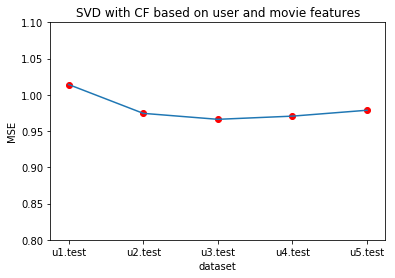

In [0]:
files=["u1.test","u2.test","u3.test","u4.test","u5.test"]

plt.plot(files,mse_list)
plt.scatter(files,mse_list,color='red')
plt.xlabel("dataset")
plt.ylabel("MSE")
plt.ylim(0.8,1.1)
plt.title('SVD with CF based on user and movie features')
plt.savefig('/content/drive/My Drive/comp9417-project/SVD based on user and movie features/MSE.png')
plt.show()

Recommand movies for user 

In [0]:
r_cols = ['userId', 'movieId', 'rating',"timeStamp"]
ratings = pd.read_csv('/content/drive/My Drive/comp9417-project/SVD based on user and movie features/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')
ratings.drop('timeStamp',axis=1, inplace=True)
# a = ratings['user_id'].value_counts().index.tolist()
m_cols = ['movieId', 'title', 'release_date'] 
movies = pd.read_csv('/content/drive/My Drive/comp9417-project/SVD based on user and movie features/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3),encoding='latin-1')
test=pd.merge(ratings,movies,how='outer',on='movieId')
trainRatingsPivotDF=test.pivot_table(index='userId',columns='movieId',values='rating',fill_value=0)
U,Sigma,VT = la.svd(mat(trainRatingsPivotDF))
lowDimension = findDimension(Sigma)
Sig4 = mat(eye(lowDimension)*Sigma[:lowDimension])
xformedMovies = mat(trainRatingsPivotDF).T*U[:,:lowDimension]*Sig4.I
xformedUsers = mat(trainRatingsPivotDF)*VT[:,:lowDimension]*Sig4.I


results=predict(trainRatingsPivotDF,user_id=1,top_k=10,cal=False)

Recommanding top 10 movies to user 1
****************************************************************************************************
score：4.03,   movie ID：1499,   movie name: Santa with Muscles (1996)
score：4.03,   movie ID：1466,   movie name: Saint of Fort Washington, The (1993)
score：4.03,   movie ID：1121,   movie name: They Made Me a Criminal (1939)
score：4.03,   movie ID：1598,   movie name: Someone Else's America (1995)
score：4.03,   movie ID：1652,   movie name: Entertaining Angels: The Dorothy Day Story (1996)
score：4.03,   movie ID：1535,   movie name: Aiqing wansui (1994)
score：4.03,   movie ID：813,   movie name: Great Day in Harlem, A (1994)
score：4.03,   movie ID：1188,   movie name: Prefontaine (1997)
score：4.02,   movie ID：1200,   movie name: Marlene Dietrich: Shadow and Light (1996) 
score：4.02,   movie ID：1292,   movie name: Star Kid (1997)
****************************************************************************************************
